## **LIBRARIES**

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
from sklearn import preprocessing
import os

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **DATASET**

In [12]:
gtzan_path = "/content/drive/MyDrive/GTZAN/Data"
audio_path = "/content/drive/MyDrive/GTZAN/Data/genres_original"
feature_csv_path = "/content/drive/MyDrive/GTZAN/Data/features_30_sec.csv"

genres = sorted(os.listdir(audio_path))

print("🎧 Türler:", genres)

🎧 Türler: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [13]:
metadata = pd.read_csv(feature_csv_path)
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [14]:
# Türleri kontrol et
genres = sorted(os.listdir(audio_path))
print("🎧 Türler:", genres)

# Özellik dosyasını oku
music_data = pd.read_csv(feature_csv_path)
print("✅ Veri boyutu:", music_data.shape)

# Label dağılımı
print("\n🎯 Label Dağılımı:")
print(music_data['label'].value_counts())

🎧 Türler: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
✅ Veri boyutu: (1000, 60)

🎯 Label Dağılımı:
label
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: count, dtype: int64


## **FEATURES**

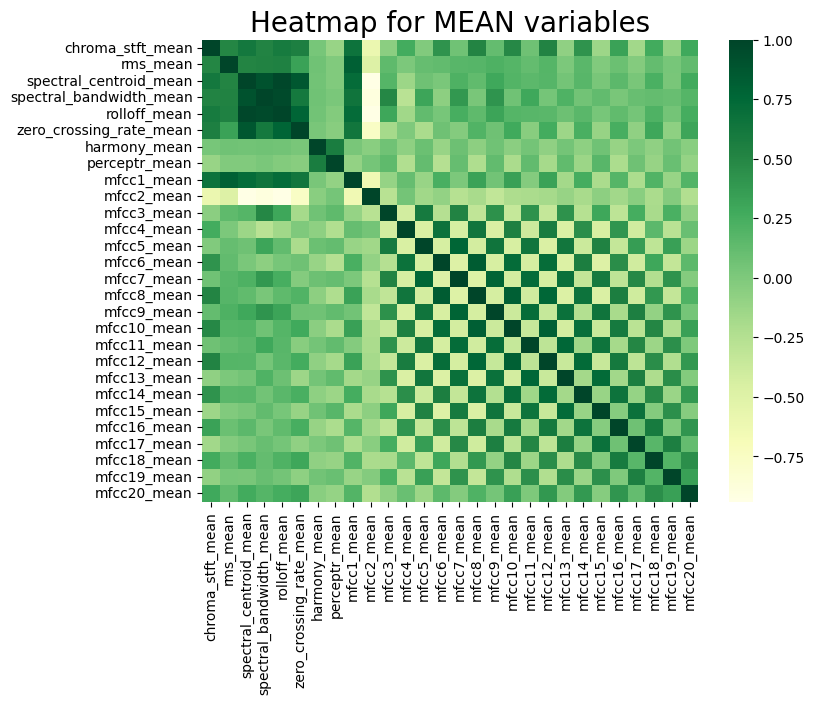

In [15]:
spike_cols = [col for col in music_data.columns if 'mean' in col]

plt.figure(figsize=(8, 6))
sns.heatmap(music_data[spike_cols].corr(), cmap='YlGn')
plt.title('Heatmap for MEAN variables', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [16]:
# Label encoding
label_encoder = preprocessing.LabelEncoder()
music_data['label'] = label_encoder.fit_transform(music_data['label'])
genre_labels = label_encoder.classes_

In [17]:
# Özellik ve hedef ayır
X = music_data.drop(columns=['label', 'filename'])
y = music_data['label']

In [18]:
# MinMax normalize
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

## **TRAIN MODEL**

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 58), (300, 58), (700,), (300,))

In [21]:
!pip install catboost xgboost

In [22]:
!pip uninstall catboost -y
!pip install catboost --no-cache-dir

Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 279.7 MB/s eta 0:00:00


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [24]:
model_configs = {
    "SVM": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10, 50],
            "gamma": ['scale', 0.1, 0.01, 0.001],
            "kernel": ['rbf', 'sigmoid']
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ['uniform', 'distance'],
            "metric": ['euclidean', 'manhattan']
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ['lbfgs', 'saga'],
            "penalty": ['l2']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=0),
        "params": {
            "n_estimators": [300, 1000],
            "max_depth": [10, 20]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='mlogloss'),
        "params": {
            "n_estimators": [100, 300, 1000],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [4, 6, 10]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, loss_function='MultiClass', eval_metric='Accuracy'),
        "params": {
            "iterations": [300],
            "depth": [6, 10],
            "learning_rate": [0.03, 0.1]
        }
    }
}

In [26]:
results = {}
predictions = {}

### **SVM**

In [27]:
from sklearn.svm import SVC

svm_model = SVC()
svm_params = {
    "C": [1, 10],
    "kernel": ['rbf'],
    "gamma": ['scale', 0.01]
}

svm_grid = GridSearchCV(svm_model, svm_params, cv=5, n_jobs=-1, verbose=1)
svm_grid.fit(X_train, y_train)

y_pred_svm = svm_grid.predict(X_test)
results["SVM"] = {
    "model": svm_grid.best_estimator_,
    "params": svm_grid.best_params_,
    "accuracy": accuracy_score(y_test, y_pred_svm),
    "report": classification_report(y_test, y_pred_svm, target_names=genres, output_dict=True),
    "conf_matrix": confusion_matrix(y_test, y_pred_svm)
}

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [28]:
print(f"SVM Accuracy: {results['SVM']['accuracy']:.4f}")
print(f"🔍 SVM Best Params: {results['SVM']['params']}")

SVM Accuracy: 0.7467
🔍 SVM Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


### **KNN**

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_params = {
    "n_neighbors": [3, 5, 7],
    "weights": ['uniform', 'distance'],
    "metric": ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(knn_model, knn_params, cv=5, n_jobs=-1, verbose=1)
knn_grid.fit(X_train, y_train)

y_pred_knn = knn_grid.predict(X_test)
results["KNN"] = {
    "model": knn_grid.best_estimator_,
    "params": knn_grid.best_params_,
    "accuracy": accuracy_score(y_test, y_pred_knn),
    "report": classification_report(y_test, y_pred_knn, target_names=genres, output_dict=True),
    "conf_matrix": confusion_matrix(y_test, y_pred_knn)
}


Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [30]:
print(f"KNN Accuracy: {results['KNN']['accuracy']:.4f}")
print(f"🔍 KNN Best Params: {results['KNN']['params']}")

KNN Accuracy: 0.7367
🔍 KNN Best Params: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


### **Logistic Regresion**

In [31]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=1000)
logreg_params = {
    "C": [0.1, 1, 10],
    "solver": ['lbfgs', 'saga'],
    "penalty": ['l2']
}

logreg_grid = GridSearchCV(logreg_model, logreg_params, cv=5, n_jobs=-1, verbose=1)
logreg_grid.fit(X_train, y_train)

y_pred_logreg = logreg_grid.predict(X_test)
results["Logistic Regression"] = {
    "model": logreg_grid.best_estimator_,
    "params": logreg_grid.best_params_,
    "accuracy": accuracy_score(y_test, y_pred_logreg),
    "report": classification_report(y_test, y_pred_logreg, target_names=genres, output_dict=True),
    "conf_matrix": confusion_matrix(y_test, y_pred_logreg)
}

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [32]:
print(f"Logistic Regression Accuracy: {results['Logistic Regression']['accuracy']:.4f}")
print(f"🔍 Logistic Regression Best Params: {results['Logistic Regression']['params']}")

Logistic Regression Accuracy: 0.7600
🔍 Logistic Regression Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}


### **RF**

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=0)
rf_params = {
    "n_estimators": [300, 1000],
    "max_depth": [10, 20]
}

rf_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

y_pred_rf = rf_grid.predict(X_test)
results["Random Forest"] = {
    "model": rf_grid.best_estimator_,
    "params": rf_grid.best_params_,
    "accuracy": accuracy_score(y_test, y_pred_rf),
    "report": classification_report(y_test, y_pred_rf, target_names=genres, output_dict=True),
    "conf_matrix": confusion_matrix(y_test, y_pred_rf)
}

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [34]:
print(f"Random Forest Accuracy: {results['Random Forest']['accuracy']:.4f}")
print(f"🔍 Random Forest Best Params: {results['Random Forest']['params']}")

Random Forest Accuracy: 0.7800
🔍 Random Forest Best Params: {'max_depth': 10, 'n_estimators': 1000}


### **XGBoost**

In [35]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_params = {
    "n_estimators": [300, 1000],
    "learning_rate": [0.05, 0.1],
    "max_depth": [6, 10]
}

xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

y_pred_xgb = xgb_grid.predict(X_test)
results["XGBoost"] = {
    "model": xgb_grid.best_estimator_,
    "params": xgb_grid.best_params_,
    "accuracy": accuracy_score(y_test, y_pred_xgb),
    "report": classification_report(y_test, y_pred_xgb, target_names=genres, output_dict=True),
    "conf_matrix": confusion_matrix(y_test, y_pred_xgb)
}

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:21:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [36]:
print(f"XGBoost Accuracy: {results['XGBoost']['accuracy']:.4f}")
print(f"🔍 XGBoost Best Params: {results['XGBoost']['params']}")

XGBoost Accuracy: 0.7733
🔍 XGBoost Best Params: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}


### **Cat Boost**

In [37]:
from catboost import CatBoostClassifier

cb_model = CatBoostClassifier(verbose=0, loss_function='MultiClass', eval_metric='Accuracy')
cb_params = {
    "iterations": [300],
    "depth": [6, 10],
    "learning_rate": [0.03, 0.1]
}

cb_grid = GridSearchCV(cb_model, cb_params, cv=5, n_jobs=-1, verbose=1)
cb_grid.fit(X_train, y_train)

y_pred_cb = cb_grid.predict(X_test)
results["CatBoost"] = {
    "model": cb_grid.best_estimator_,
    "params": cb_grid.best_params_,
    "accuracy": accuracy_score(y_test, y_pred_cb),
    "report": classification_report(y_test, y_pred_cb, target_names=genres, output_dict=True),
    "conf_matrix": confusion_matrix(y_test, y_pred_cb)
}

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [40]:
print(f"CatBoost Accuracy: {results['CatBoost']['accuracy']:.4f}")
print(f"🔍 CatBoost Best Params: {results['CatBoost']['params']}")

CatBoost Accuracy: 0.8067
🔍 CatBoost Best Params: {'depth': 6, 'iterations': 300, 'learning_rate': 0.1}


## **Eval**

In [44]:
for name in results:
    model = results[name]["model"]
    predictions[name] = model.predict(X_test)

In [46]:
for name in results:
    print(f"\n📈 {name} - Accuracy: {results[name]['accuracy']:.4f}")
    print(f"🔍 En iyi parametreler: {results[name]['params']}")
    print(classification_report(y_test, predictions[name], target_names=genres))



📈 SVM - Accuracy: 0.7467
🔍 En iyi parametreler: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

       blues       0.74      0.77      0.75        30
   classical       0.94      0.97      0.95        32
     country       0.71      0.74      0.73        27
       disco       0.59      0.53      0.56        30
      hiphop       0.68      0.79      0.73        24
        jazz       0.85      0.76      0.80        29
       metal       0.81      0.86      0.83        29
         pop       0.85      0.81      0.83        36
      reggae       0.66      0.66      0.66        32
        rock       0.60      0.58      0.59        31

    accuracy                           0.75       300
   macro avg       0.74      0.75      0.74       300
weighted avg       0.75      0.75      0.75       300


📈 KNN - Accuracy: 0.7367
🔍 En iyi parametreler: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
              precision    recall

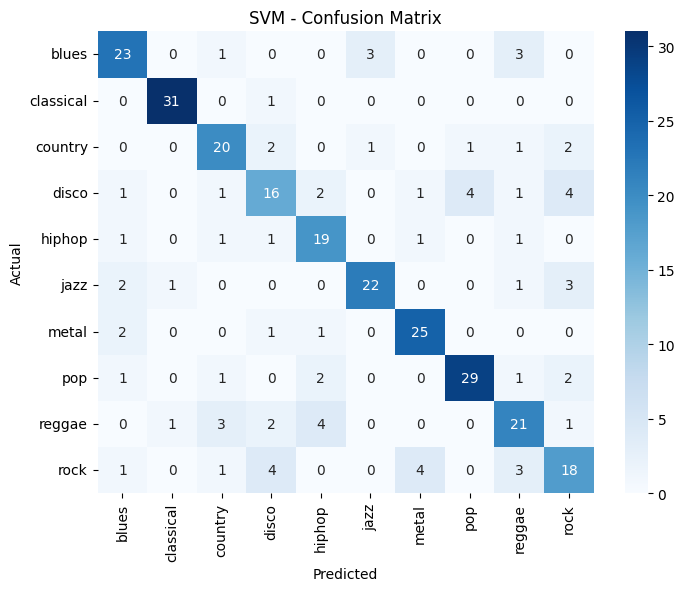

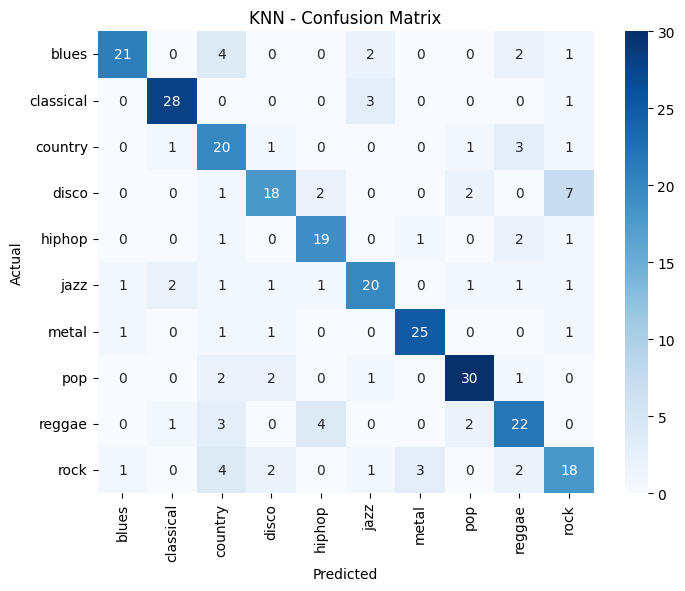

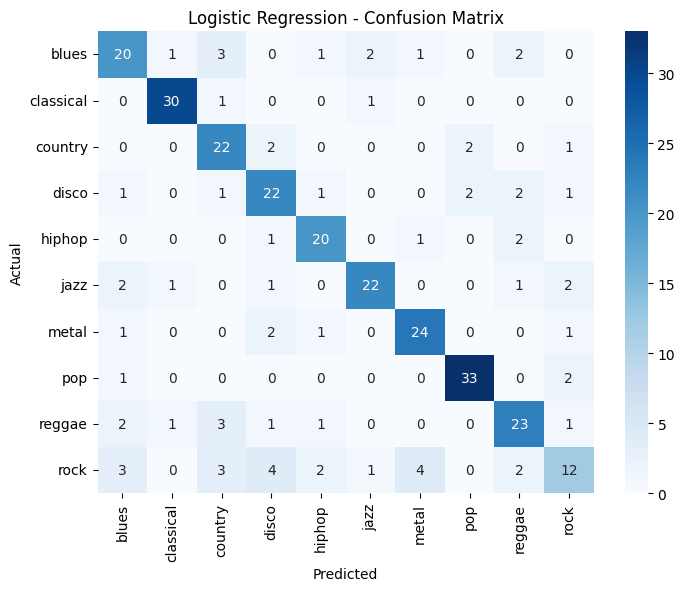

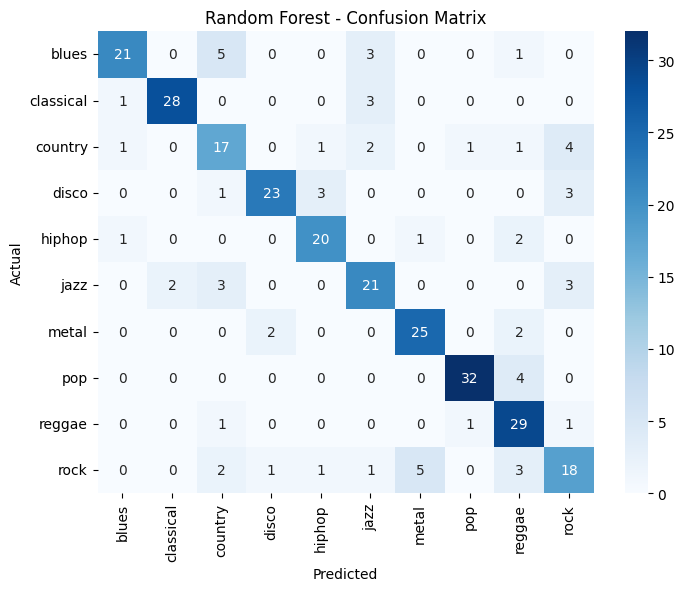

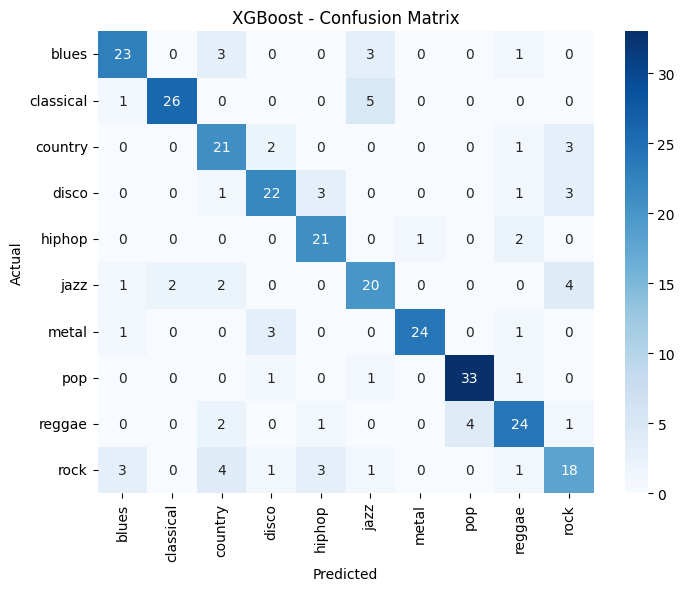

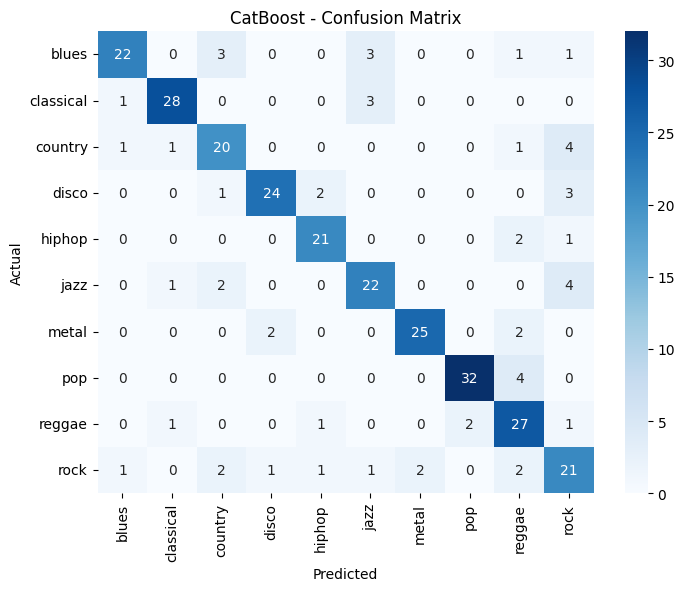

In [47]:
for name in results:
    plt.figure(figsize=(8, 6))
    sns.heatmap(results[name]['conf_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=genres, yticklabels=genres)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()